In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product
import seaborn as sns
from collections import defaultdict

Populating the interactive namespace from numpy and matplotlib


/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Загружаем список регионов и данные с фильтрациями и подклееными регионами с прошлой недели.

In [2]:
data = pd.read_csv('tmp.csv', index_col=0)
region = pd.read_csv('regions.csv', delimiter=';')

/anaconda2/lib/python2.7/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Посчитаем среднее число в час поезд ок за месяц из каждой ячейки. Всего часов было 744.

In [3]:
count = [0 for _ in range(2500)]
for item in data[['region']].values:
    count[item[0]] += 1/744.0

Посмотрим на список регионов в которых было в среднем не менее чем 5 поездок в час.

In [5]:
[index for index, item in enumerate(count) if item >= 5]

[1075,
 1076,
 1077,
 1125,
 1126,
 1127,
 1128,
 1129,
 1130,
 1131,
 1132,
 1172,
 1173,
 1174,
 1175,
 1176,
 1177,
 1178,
 1179,
 1180,
 1181,
 1182,
 1183,
 1184,
 1221,
 1222,
 1223,
 1224,
 1225,
 1227,
 1228,
 1229,
 1230,
 1231,
 1232,
 1233,
 1234,
 1235,
 1272,
 1273,
 1274,
 1278,
 1279,
 1280,
 1281,
 1282,
 1283,
 1284,
 1285,
 1286,
 1287,
 1326,
 1327,
 1331,
 1332,
 1333,
 1334,
 1335,
 1336,
 1337,
 1338,
 1339,
 1376,
 1377,
 1378,
 1380,
 1382,
 1383,
 1384,
 1385,
 1386,
 1387,
 1388,
 1389,
 1390,
 1426,
 1431,
 1434,
 1435,
 1436,
 1437,
 1438,
 1439,
 1441,
 1442,
 1480,
 1482,
 1483,
 1530,
 1532,
 1533,
 1580,
 1630,
 1684,
 1733,
 1734,
 1783,
 2068,
 2069,
 2118,
 2119,
 2168]

Выберем из них 1. Пусть это будет регион 1333. Найдём его границы.

In [7]:
target_region = region[region.region == 1333]

In [13]:
target_region

,region,west,east,south,north
1332,1333,-73.966688,-73.955577,40.764542,40.772931


Загружаем оригинальные данные за год.

In [19]:
data = pd.DataFrame(columns=['tpep_pickup_datetime'])
for date in pd.date_range('2016-01-01', '2016-06-01', freq='M'):
    file_name = 'cs_data/yellow_tripdata_{}.csv'.format(str(date)[:7])
    print "Load {}".format(file_name)
    tmp = pd.read_csv(file_name, index_col=0)
    tmp = tmp[
        (target_region.west.values[0] <= tmp.pickup_longitude) &
        (tmp.pickup_longitude <= target_region.east.values[0]) &
        (target_region.south.values[0] <= tmp.pickup_latitude) &
        (tmp.pickup_latitude <= target_region.north.values[0]) &
        (tmp.passenger_count > 0) &
        (tmp.tpep_pickup_datetime < tmp.tpep_dropoff_datetime) &
        (tmp.trip_distance > 0)
    ]
    data = data.append(tmp[['tpep_pickup_datetime']])

Load cs_data/yellow_tripdata_2016-01.csv
Load cs_data/yellow_tripdata_2016-02.csv
Load cs_data/yellow_tripdata_2016-03.csv
Load cs_data/yellow_tripdata_2016-04.csv
Load cs_data/yellow_tripdata_2016-05.csv


In [20]:
data.head()

,tpep_pickup_datetime
2,2016-01-01 00:00:36
2,2016-01-29 09:18:21
1,2016-01-29 09:18:22
2,2016-01-29 09:18:23
1,2016-01-29 09:18:26


Посчитаем число заказов в разбивке по часам. На будущее сохраним результат агрегации в файле.

In [21]:
count = defaultdict(int)
for item in data.tpep_pickup_datetime.values:
    time = item[:13] + ':00:00'
    count[time] += 1

In [22]:
counts = pd.DataFrame([[key, value] for key, value in count.iteritems()], columns=['hour', 'taxi_cnt'])
counts.to_csv('my_data.csv', index=False)

In [23]:
counts = pd.read_csv('my_data.csv', index_col=['hour'], parse_dates=['hour'], dayfirst=True)
counts.sort_index(inplace=True)

Посмотрим на график числа поездок из этой области.

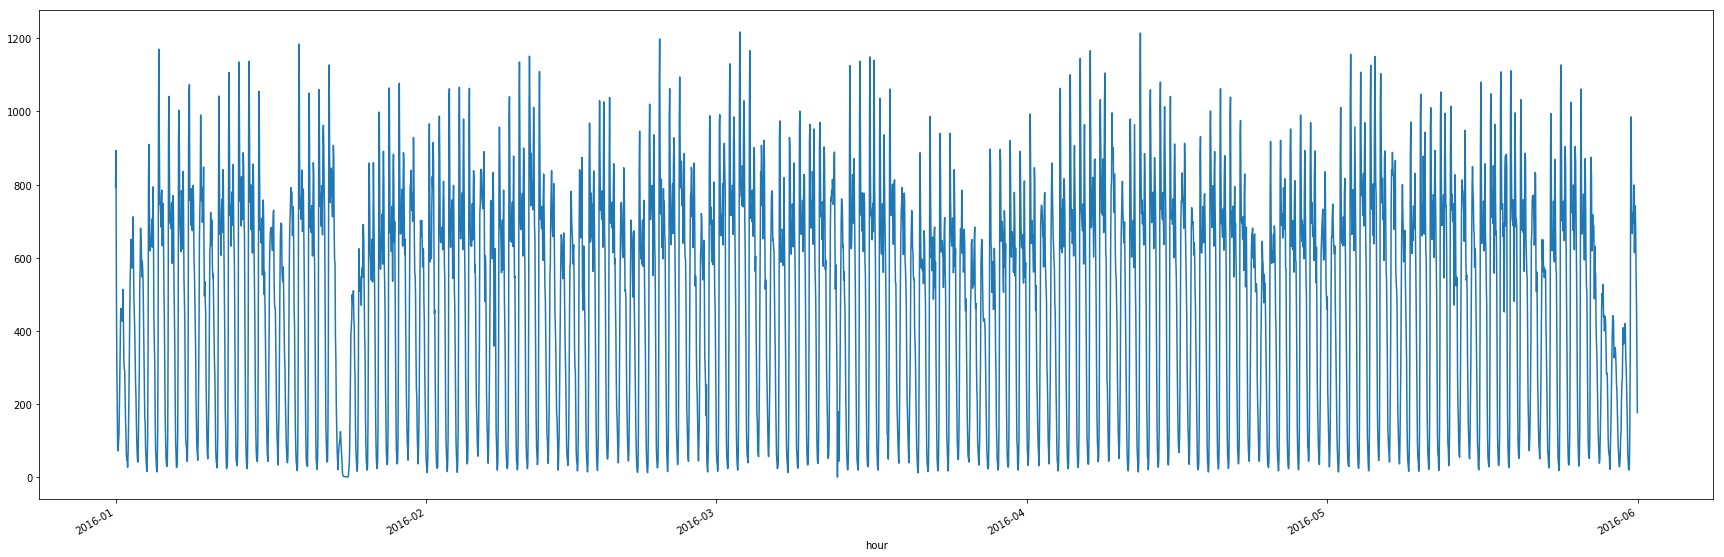

In [24]:
plt.figure(figsize(30,10))
counts.taxi_cnt.plot()

In [28]:
counts.shape

(3638, 1)

Явный тренд отсутствует. Поэтому просто создадим регрессионные признаки.
Возьмём k равным 5.

In [29]:
list_factors = list()
for index in xrange(1, 3639):
    factors = dict()
    for i in xrange(1, 6):
        factors['week_s_{}'.format(i)] = sin(i * index * 2 * pi / 168)
        factors['week_c_{}'.format(i)] = cos(i * index * 2 * pi / 168)
    list_factors.append(factors)
reg_factors = pd.DataFrame(list_factors)

In [30]:
reg_factors.head()

,week_c_1,week_c_2,week_c_3,week_c_4,week_c_5,week_s_1,week_s_2,week_s_3,week_s_4,week_s_5
0,0.999301,0.997204,0.993712,0.988831,0.982566,0.037391,0.074730,0.111964,0.149042,0.185912
1,0.997204,0.988831,0.974928,0.955573,0.930874,0.074730,0.149042,0.222521,0.294755,0.365341
2,0.993712,0.974928,0.943883,0.900969,0.846724,0.111964,0.222521,0.330279,0.433884,0.532032
3,0.988831,0.955573,0.900969,0.826239,0.733052,0.149042,0.294755,0.433884,0.563320,0.680173
4,0.982566,0.930874,0.846724,0.733052,0.593820,0.185912,0.365341,0.532032,0.680173,0.804598


# 2. Сделайте регрессию целевого признака
Чтобы примерно подобрать порядки дифференцирования ряда в модели ARIMA, сделайте регрессию целевого признака — количества поездок — на построенные признаки. Посмотрите на остатки регрессии. Если регрессионные признаки подобраны идеально, то в них должна остаться только внутрисуточная сезонность. Вслепую идеально подобрать признаки вам вряд ли удастся, так что в остатках вы, скорее всего, увидите много интересного, в том числе праздники, аномалии, тренды и многое другое.

In [34]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
regr = LinearRegression()
regr.fit(reg_factors, counts.taxi_cnt.values)
print 'Коэффициенты:'
list(zip(reg_factors.columns, regr.coef_))

Коэффициенты:


[('week_c_1', 36.943081720442649),
 ('week_c_2', 19.614106267972424),
 ('week_c_3', -5.5180379124607342),
 ('week_c_4', 5.5193717894860237),
 ('week_c_5', 21.125672506326154),
 ('week_s_1', -62.154726008689209),
 ('week_s_2', 15.827674544961356),
 ('week_s_3', -5.2676595668192867),
 ('week_s_4', -11.625452511391595),
 ('week_s_5', 14.672182511409227)]

In [94]:
value = reg_factors * [53.209, 7.245, 1.397, 14.818, -23.535, -49.431, 23.238, -8.122, 5.124, 23.113]
result = value.week_c_1 + value.week_c_2 + value.week_c_3 + value.week_c_4 + value.week_c_5 \
       + value.week_s_1 + value.week_s_2 + value.week_s_3 + value.week_s_4 + value.week_s_5 + 491.731
result.index = counts.index

Найдём остатки и построим график.

In [95]:
diff = counts.taxi_cnt - result

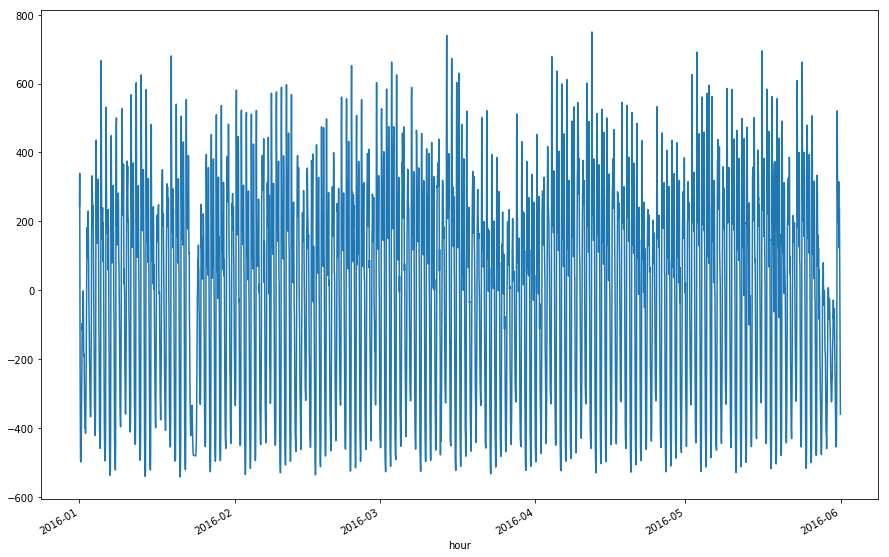

In [96]:
diff.plot()

# 3. Подберите значения гиперпараметров ARIMA для ряда остатков
Чтобы подобрать значения гиперпараметров ARIMA, попробуйте сделать ряд остатков стационарным. Если необходимо, сделайте несколько дифференцирований. Из-за большого количества аномальных дней (праздники и т.д.) вряд ли вам удастся сделать так, что критерий Дики-Фуллера не будет отвергать гипотезу нестационарности, поэтому при выборе порядка дифференцирования ориентируйтесь в первую очередь на результат STL-декомпозиции.

Попробуем сделать ряд остатков стационарным. Продифференцируем остатки по дням:

In [122]:
dff = diff - diff.shift(24)

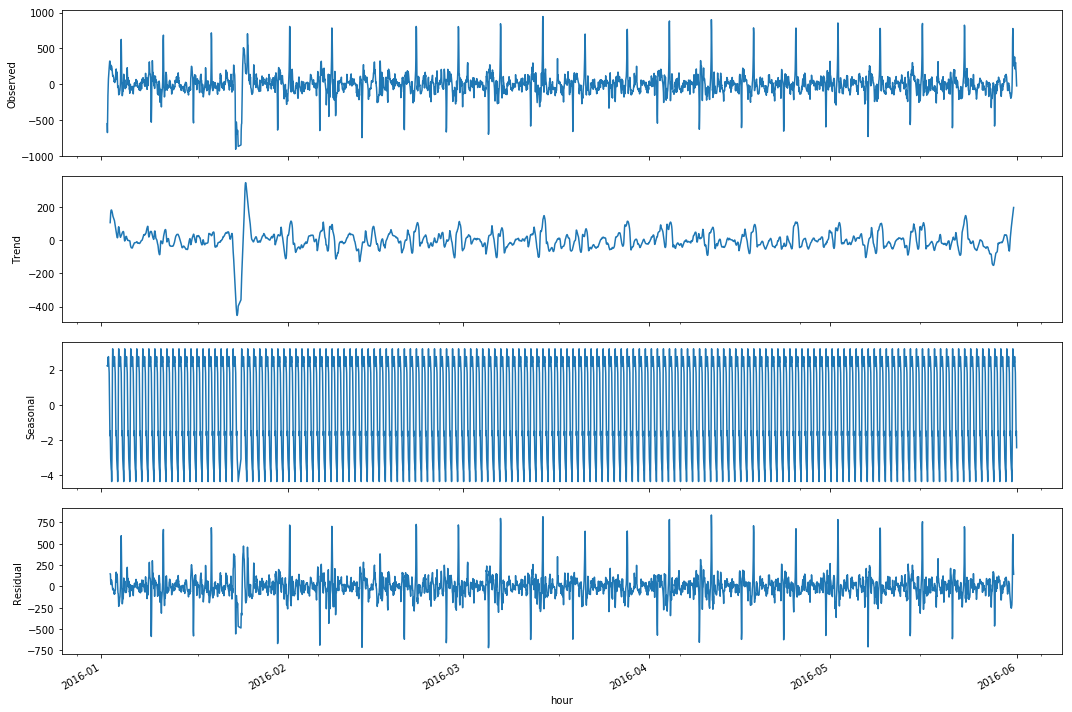

In [123]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(dff[24:], freq=24).plot()
plt.show()

Тренда практически нет, на графике хорошо заметны аномалии. В остатках присутствует не только дневная, но и недельная сезонность.

Выполним обычное дифференцирование исходного ряда:

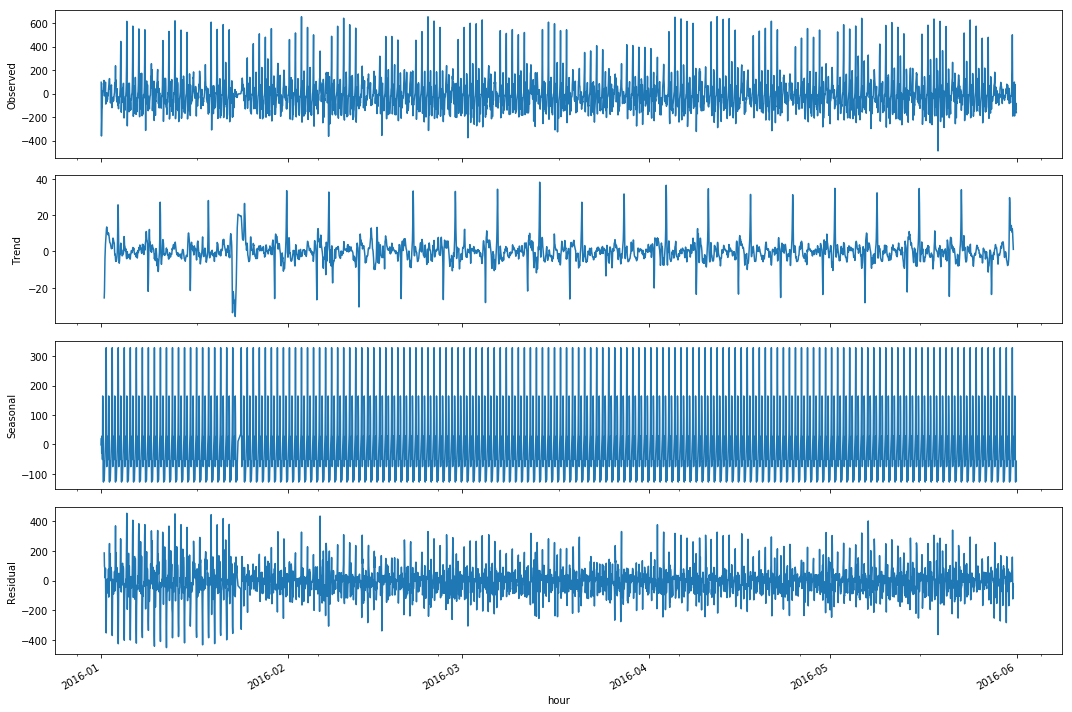

In [125]:
dff_h = diff - diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(dff_h[1:], freq=24).plot()
plt.show()

Посмотрим STL-декомпозицию ряда, которой продифференцировали сначала по дням, потом по часам:

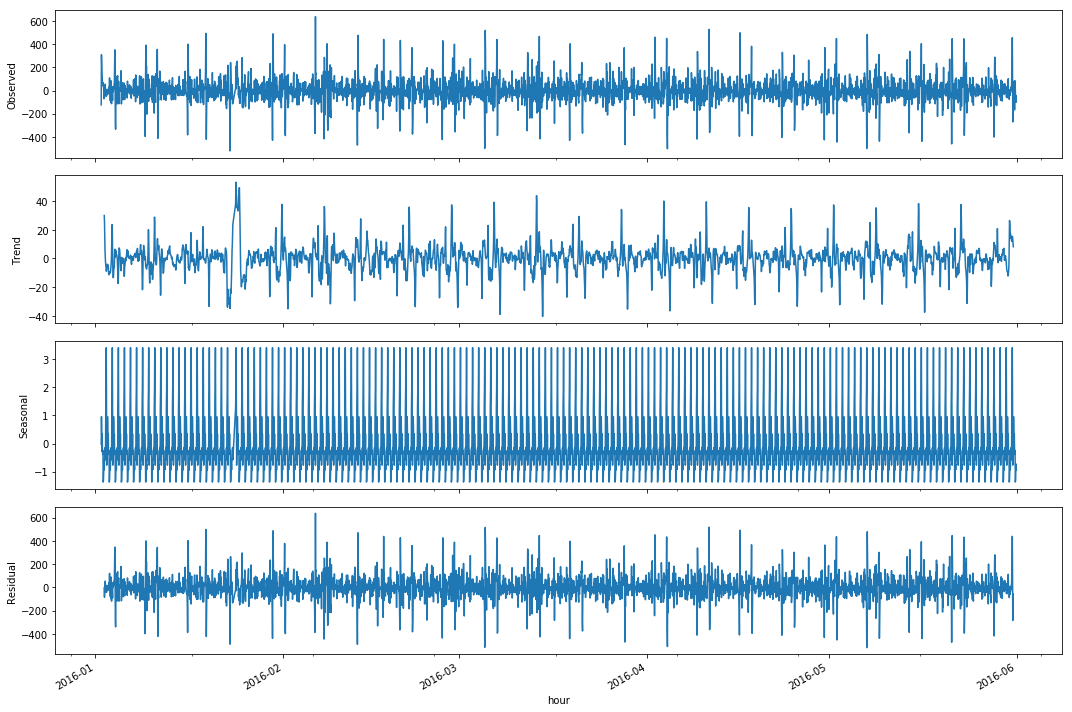

In [128]:
dff_d_h = dff - dff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(dff_d_h[25:], freq=24).plot()
plt.show()

Все три преобразования сработали примерно одинаково. Поэтому в будущем я буду рассматривать все эти варианты при построении моделей.

В каждом случае тест ADF (Дики-Фуллера) находят ряд стационарным.

# 4. Подберите начальные приближения для параметров p, q, P, Q
Постройте ACF и PACF полученного ряда остатков (возможно, продифференцированных) с максимальным лагом не меньше длины самого длинного сезонного периода (неделя или год), подберите по ним начальные приближения для параметров p,q,P,Q. Используйте эти начальные приближения при переборе моделей ARIMA исходного ряда, не забывая подавать функции SARIMAX регрессионные признаки.

Построим графики acf/pacf, для удобства возьмем лаги за неделю.

График для ряда остатков:

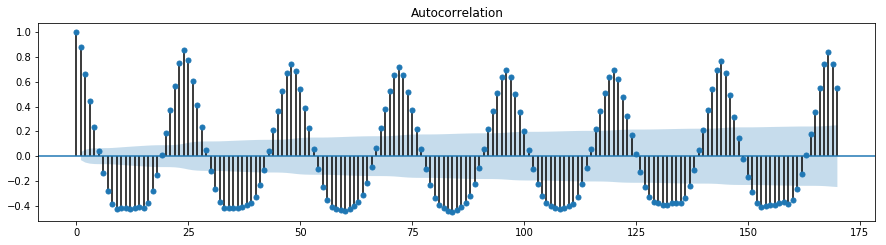

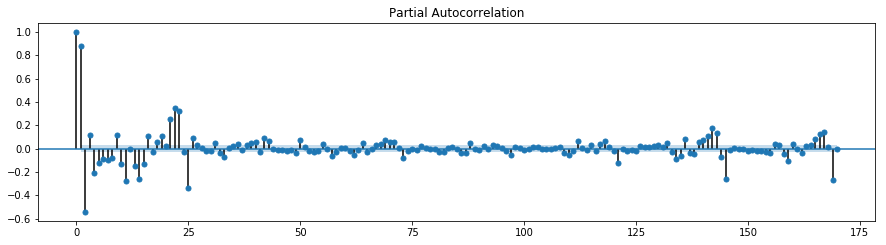

In [130]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(diff, lags=170, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(diff, lags=170, ax=ax)
pylab.show()

График для ряда остатков дифференцированных по дням:

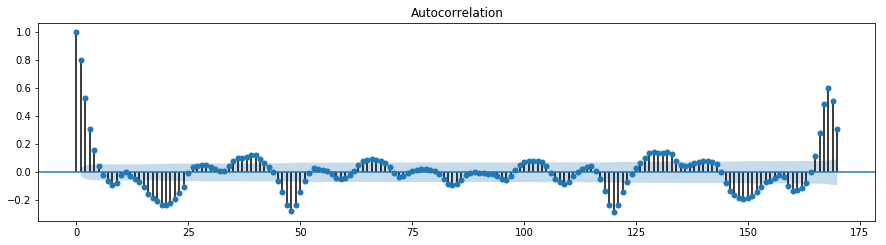

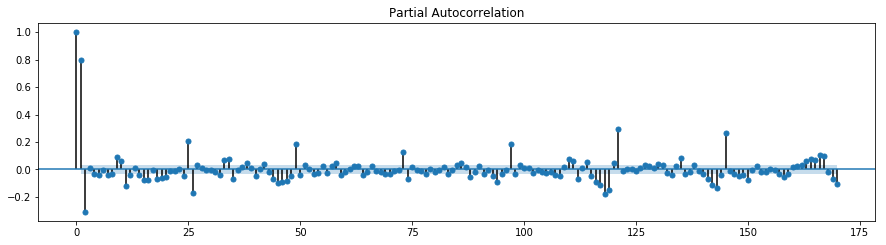

In [133]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(dff[24:], lags=170, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(dff[24:], lags=170, ax=ax)
pylab.show()

График для ряда остатков дифференцированных по часам:

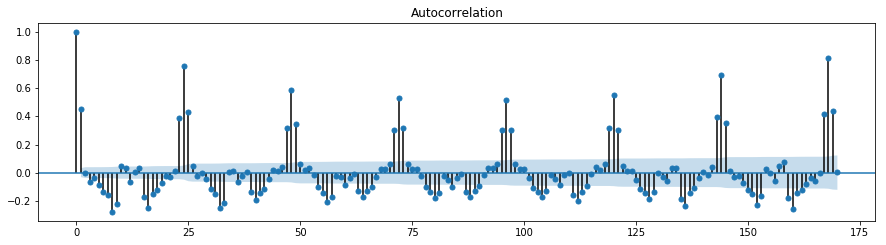

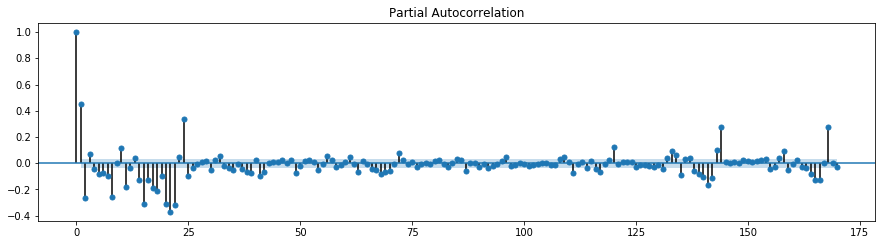

In [134]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(dff_h[1:], lags=170, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(dff_h[1:], lags=170, ax=ax)
pylab.show()

График для ряда остатков дифференцированных по дням и по часам:

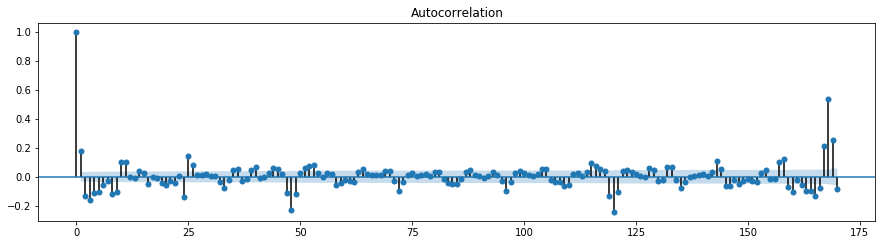

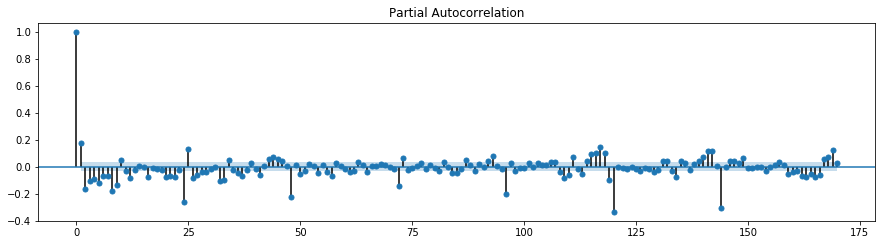

In [135]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(dff_d_h[25:], lags=170, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(dff_d_h[25:], lags=170, ax=ax)
pylab.show()

В рядах осталось много структуры. По последнему графику можно выбрать p = 16, P = 6, q = 11, Q = 7. Но это займёт очень много времени. Для начала остановимс на приблежениях: p = q = 7, P = Q = 2.

# 5. Выберите оптимальную по AIC модель
Выберите оптимальную по AIC модель; постройте график исходного ряда и нарисуйте поверх предсказания выбранной модели. Если модель плохо описывает данные, попробуйте увеличить количество синусов и косинусов K или поменять порядки дифференцирования.

In [137]:
ps = range(0, 8)
d=1
qs = range(0, 8)
Ps = range(0, 3)
D=1
Qs = range(0, 3)

In [138]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print "Всего комбинаций параметров:", len(parameters_list)

Всего комбинаций параметров: 576


Обучим модели для созданных комбинаций параметров. При этом покажем неверные комбинации (на которых модель не обучается) и покажем рассчетное время:

In [143]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(counts.taxi_cnt, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)
    except ValueError:
        print 'wrong parameters:', param
        continue
    except LinAlgError:
        print 'LinAlgError parameters:', param
        continue
    aic = model.aic

    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
wrong parameters: (0, 0, 1, 2)
wrong parameters: (0, 0, 2, 2)
wrong parameters: (0, 1, 1, 2)
wrong parameters: (0, 1, 2, 2)
wrong parameters: (0, 2, 1, 2)
wrong parameters: (0, 2, 2, 2)
wrong parameters: (0, 3, 1, 2)
wrong parameters: (0, 3, 2, 2)
wrong parameters: (0, 4, 1, 2)
wrong parameters: (0, 4, 2, 2)
wrong parameters: (0, 5, 1, 2)
wrong parameters: (0, 5, 2, 2)
wrong parameters: (0, 6, 1, 2)
wrong parameters: (0, 6, 2, 2)
wrong parameters: (0, 7, 1, 2)
wrong parameters: (0, 7, 2, 2)
wrong parameters: (1, 0, 1, 2)
wrong parameters: (1, 0, 2, 2)
wrong parameters: (1, 1, 1, 2)
wrong parameters: (1, 1, 2, 2)
wrong parameters: (1, 2, 0, 0)
wrong parameters: (1, 2, 0, 1)
wrong parameters: (1, 2, 0, 2)
wrong parameters: (1, 2, 1, 0)
wrong parameters: (1, 2, 1, 1)
wrong parameters: (1, 2, 1, 2)
wrong parameters: (1, 2, 2, 0)
wrong parameters: (1, 2, 2, 1)
wrong parameters: (1, 2, 2, 2)
wrong parameters: (1, 3, 1, 2)
wrong parameters: (1, 3, 2, 2)
wrong pa

Пять лучших результатов:

In [144]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print result_table.sort_values(by = 'aic', ascending=True).head()

       parameters           aic
320  (7, 1, 2, 1)  41660.438758
229  (5, 1, 2, 1)  41663.612263
278  (6, 1, 2, 1)  41664.343899
285  (6, 2, 2, 1)  41665.205730
327  (7, 2, 2, 1)  41668.250066


Параметры лучшей модели:

In [145]:
print best_model.summary()

                                 Statespace Model Results                                 
Dep. Variable:                           taxi_cnt   No. Observations:                 3638
Model:             SARIMAX(7, 1, 1)x(2, 1, 1, 24)   Log Likelihood              -20818.219
Date:                            Thu, 15 Mar 2018   AIC                          41660.439
Time:                                    17:03:17   BIC                          41734.829
Sample:                                01-01-2016   HQIC                         41686.936
                                     - 05-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1139      0.014     78.026      0.000       1.086       1.142
ar.L2         -0.3608      0.022   

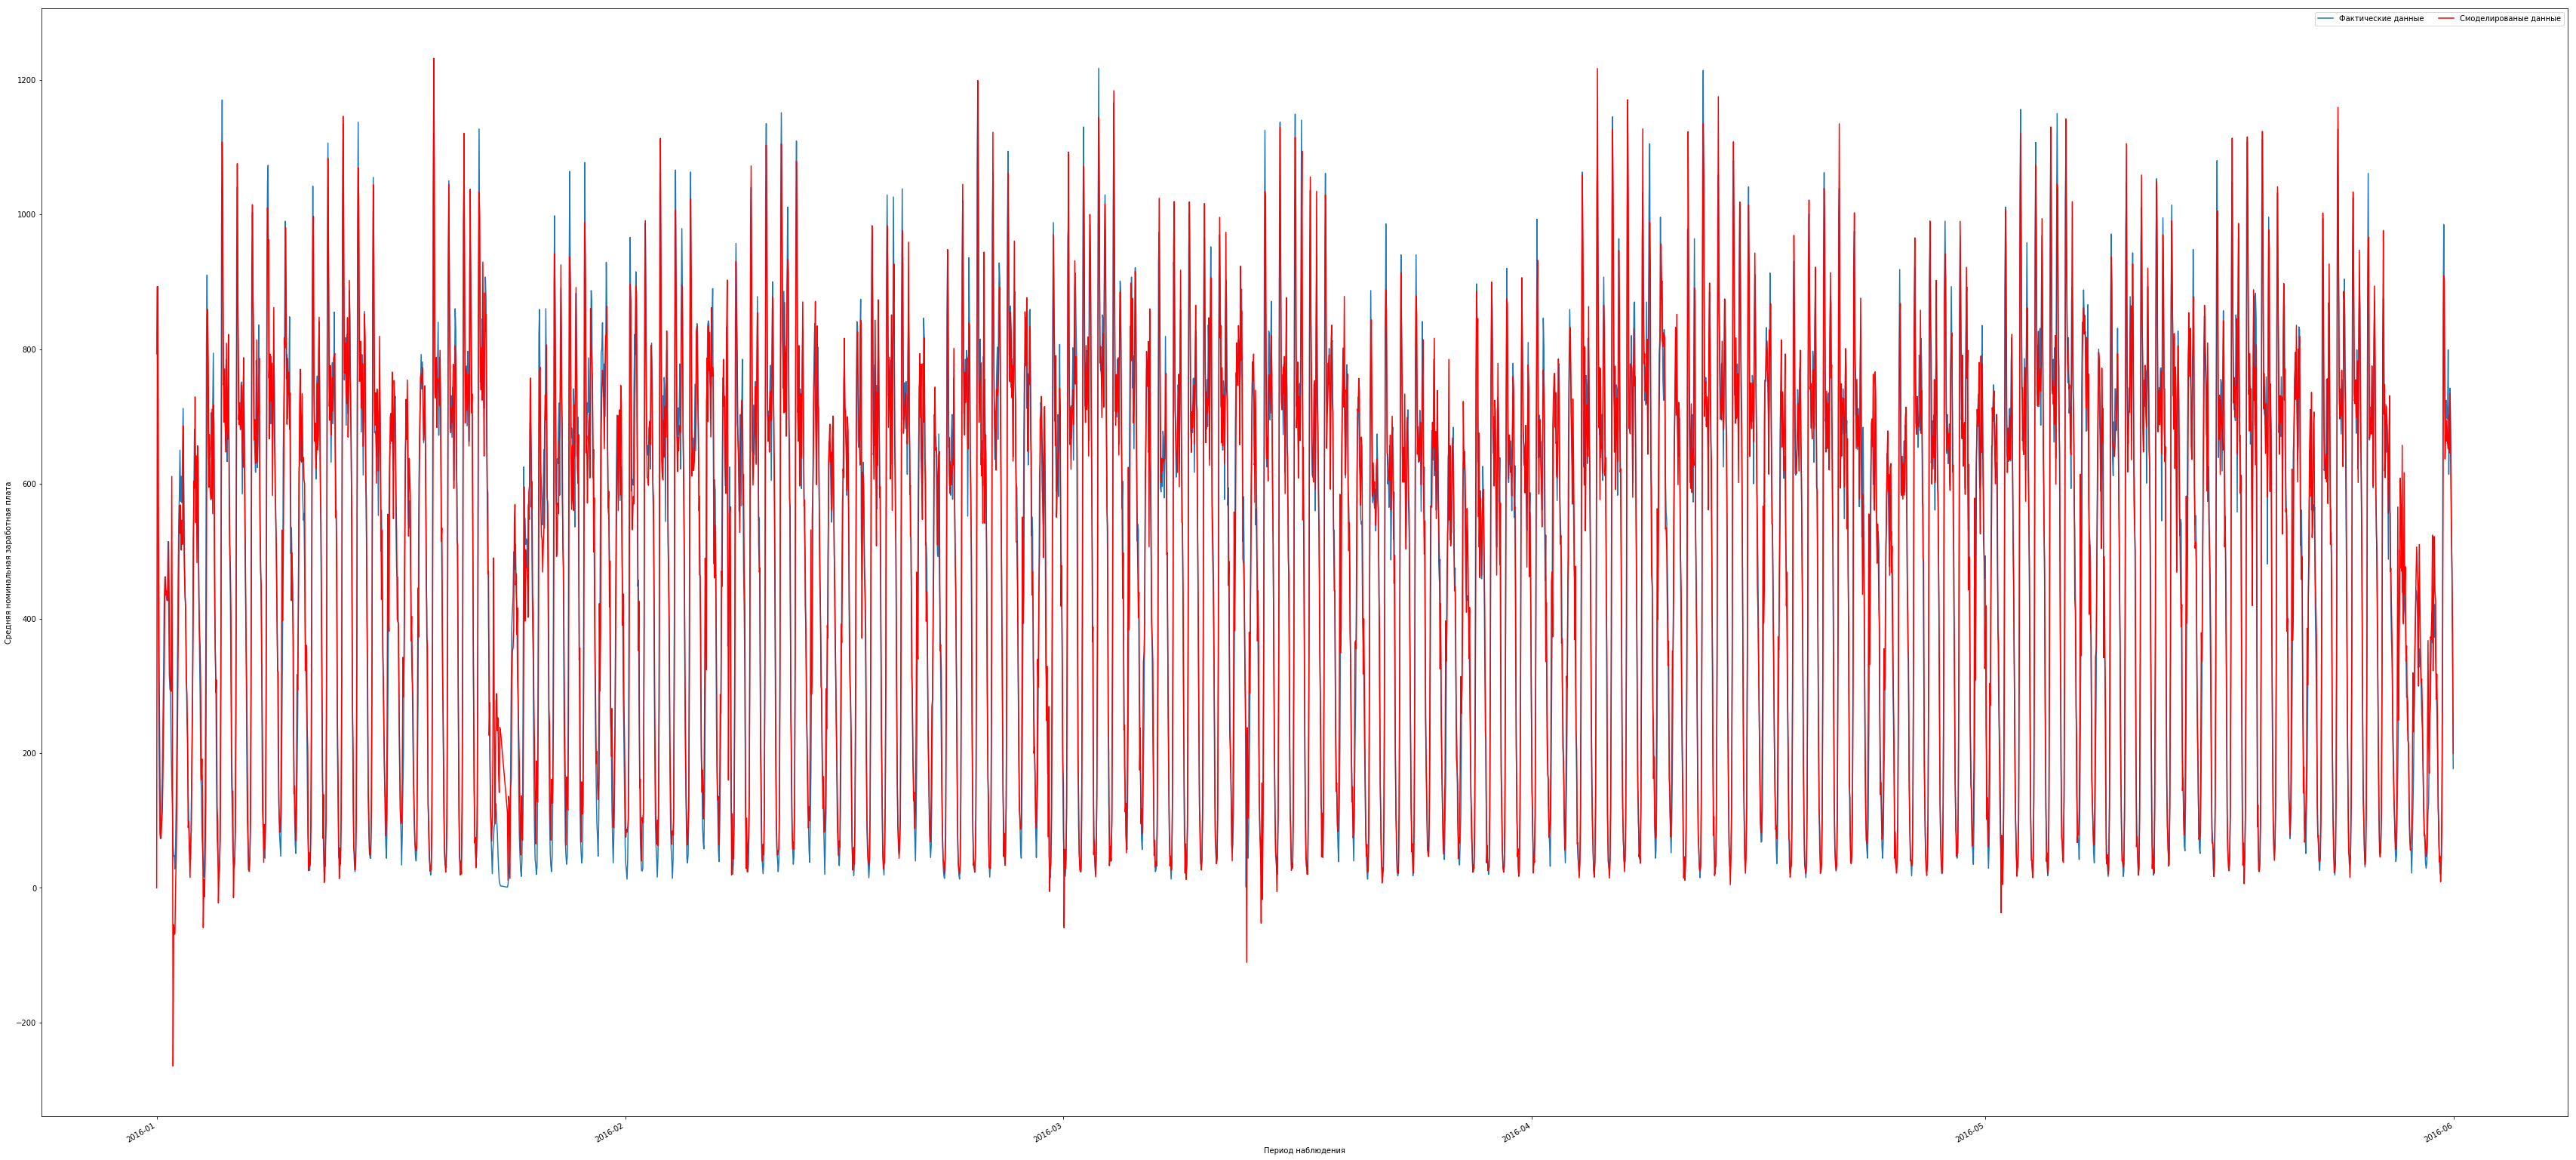

In [156]:
warnings.filterwarnings('ignore')
plt.figure(figsize(60, 30))
plot1 = counts.taxi_cnt.plot()
plot2 = best_model.fittedvalues.plot(color='r')
plt.ylabel(u'Средняя номинальная заработная плата')
plt.xlabel(u'Период наблюдения')
plt.legend( [u'Фактические данные', u'Смоделированые данные'], loc=1, ncol = 2, prop={'size':10})
pylab.show()
warnings.filterwarnings('default')

# 6. Проанализируйте качество построенной модели
Проанализируйте качество построенной модели. Опишите, в какие периоды она плохо описывает данные? Можно ли заранее предсказать её поведение в такие периоды и улучшить тем самым прогноз? Если да, попробуйте создать для таких периодов регрессионные признаки и вернитесь к пункту 2.

Из графиков выше видно что в целом модель не плохо описывает данные.
Но сильно ошибается не только в праздничные дни. Какой-то закономерности в этих периодах установить не удалось.